## Etapa 0: Conexión con Google Sheets

Antes de procesar los datos, debemos conectarnos con Google Sheets para cargar el archivo que contiene la base de datos. Este proceso se realiza una sola vez por sesión y requiere autenticación del usuario de Google.

A continuación, instalamos las librerías necesarias, realizamos la autenticación y cargamos el archivo desde la URL proporcionada.

In [1]:
# 1. Instalamos librerías necesarias para trabajar con Google Sheets
!pip install --upgrade gspread gspread-dataframe

In [3]:
# 2. Importamos librerías y autenticamos
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default

# Autenticación
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [4]:
# 3. Abrimos la hoja de cálculo y cargamos los datos en un DataFrame
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/16goZeoHV7c8HoGmZDNBSjhozXrmOok9sr_J4-XhHDhQ/edit?usp=sharing')
worksheet = spreadsheet.sheet1
df = get_as_dataframe(worksheet)
df.head()

,ID_IE,ID_SECCION,cor_est,cod_DRE,nom_dre,cod_UGEL,nom_ugel,codgeo,departamento,provincia,...,gestion2,area,sexo,M500_EM_6P_2024_CT,grupo_EM_6P_2024_CT,M500_EM_6P_2024_MA,grupo_EM_6P_2024_MA,peso_Lectura,peso_Mate,Estrato_DRE
0,1808,2,3,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,479.153,2.0,507.684,2.0,8.585908,8.585908,8001
1,1808,2,4,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,470.146,2.0,413.986,1.0,8.585908,8.585908,8001
2,1808,2,5,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,469.963,2.0,419.353,1.0,8.585908,8.585908,8001
3,1808,2,6,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,2,447.932,2.0,419.988,1.0,8.585908,8.585908,8001
4,1808,2,7,800,Cusco,80002,Acomayo,80201,CUSCO,ACOMAYO,...,1,1,1,519.260,2.0,549.413,3.0,8.585908,8.585908,8001


## Etapa 1: Importación de librerías

Importamos las librerías necesarias para manipular los datos y construir el modelo de Árbol de Decisión.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## Etapa 2: Carga y preparación de datos

Seleccionamos las variables independientes (`sexo`, `gestion2`, `area`) y la variable dependiente (`grupo_EM_6P_2024_MA`) del DataFrame cargado desde Google Sheets.

In [6]:
df_modelo = df[['sexo', 'gestion2', 'area', 'grupo_EM_6P_2024_MA']].dropna()
df_modelo.head()

,sexo,gestion2,area,grupo_EM_6P_2024_MA
0,1,1,1,2.0
1,1,1,1,1.0
2,1,1,1,1.0
3,2,1,1,1.0
4,1,1,1,3.0


## Etapa 3: Codificación de variables

Transformamos las variables categóricas en valores numéricos usando `LabelEncoder` para que el modelo pueda procesarlas.

In [7]:
le = LabelEncoder()
for col in ['sexo', 'gestion2', 'area', 'grupo_EM_6P_2024_MA']:
    df_modelo[col] = le.fit_transform(df_modelo[col])

X = df_modelo[['sexo', 'gestion2', 'area']]
y = df_modelo['grupo_EM_6P_2024_MA']

## Etapa 4: División de datos y entrenamiento del modelo

Se divide el conjunto de datos en entrenamiento y prueba (80%-20%) y se entrena el modelo de Árbol de Decisión.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Etapa 5: Evaluación del modelo

Evaluamos el rendimiento del modelo utilizando la matriz de confusión y el reporte de clasificación.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3625
           1       0.39      0.94      0.55      8079
           2       0.32      0.08      0.12      6022
           3       0.00      0.00      0.00      2979

    accuracy                           0.39     20705
   macro avg       0.18      0.25      0.17     20705
weighted avg       0.25      0.39      0.25     20705



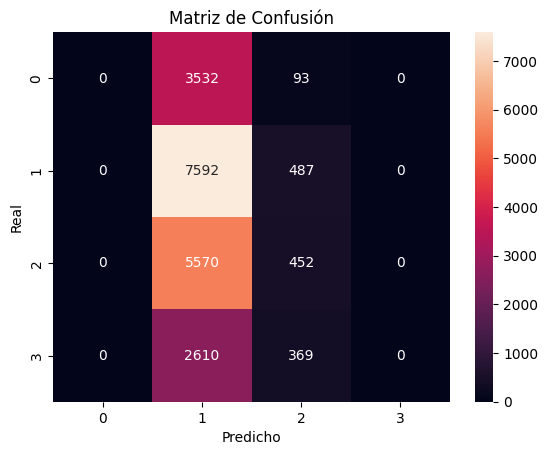

In [9]:
y_pred = modelo_arbol.predict(X_test)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

## Etapa 6: Visualización del árbol de decisión

Visualizamos el árbol de decisión para entender cómo se clasifican los estudiantes según las variables sociodemográficas.

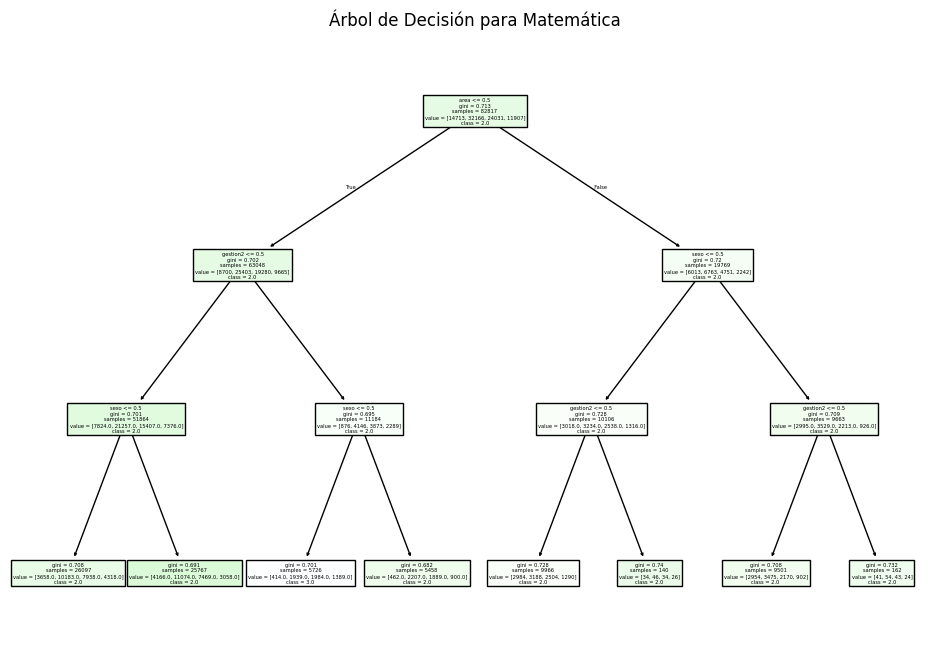

In [11]:
plt.figure(figsize=(12,8))
# Convert le.classes_ to strings before passing to plot_tree
plot_tree(modelo_arbol, feature_names=X.columns, class_names=le.classes_.astype(str), filled=True)
plt.title('Árbol de Decisión para Matemática')
plt.show()